In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *

The below cell is about

In [3]:
models = ['CNN','RF','GB']
datasets = ['MNIST','GTSRB_RGB','SignLanguage','Fashion','CIFAR_RGB']
series =[]
for dataset in datasets:
    for model in models:
        serie = compare_calib_table(model_name=model,dataset_name=dataset,fitting = 'isotonic_regression',err_metric='ECE')
        series.append(serie)

CNN-MNIST:
MNIST-CNN-stability:  0.002871193995118818+-0.0007555850646820007
MNIST-CNN-sep:  0.0030827882727934484+-0.0006893436246300723
MNIST-CNN-sklearn:  0.0031720520101754745+-0.0003796888851265853
MNIST-CNN-Base:  0.008185034811496728+-0.0007424660166781005
MNIST-CNN-SBC:  0.01900041983600475+-0.001834830380289365
MNIST-CNN-HB:  0.004532066007179527+-0.00044340021370288096


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
CNN-MNIST,0.0029+-0.0008,0.0031+-0.0007,0.0032+-0.0004,0.0082+-0.0007,0.0190+-0.0018,0.0045+-0.0004


RF-MNIST:
MNIST-RF-stability:  0.004367789400895705+-0.0005399931821688242
MNIST-RF-sep:  0.004537107303579059+-0.0005679677494686468
MNIST-RF-sklearn:  0.00980412335498948+-0.0011784510548416196
MNIST-RF-Base:  0.1628779623389904+-0.001572455705851572
MNIST-RF-SBC:  0.033079098873308434+-0.0017193495814586054
MNIST-RF-HB:  0.007769800268038395+-0.0009186682785837482


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
RF-MNIST,0.0044+-0.0005,0.0045+-0.0006,0.0098+-0.0012,0.1629+-0.0016,0.0331+-0.0017,0.0078+-0.0009


GB-MNIST:
MNIST-GB-stability:  0.0039838785385857365+-0.0006825425118557413
MNIST-GB-sep:  0.0040069845034887905+-0.0007570249911727964
MNIST-GB-sklearn:  0.017550469056491998+-0.001442304051006496
MNIST-GB-Base:  0.017267812362200638+-0.0010271445515828911
MNIST-GB-SBC:  0.038364407314215386+-0.002503635471417541
MNIST-GB-HB:  0.007398909329828039+-0.0011642637239642388


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
GB-MNIST,0.0040+-0.0007,0.0040+-0.0008,0.0176+-0.0014,0.0173+-0.0010,0.0384+-0.0025,0.0074+-0.0012


CNN-GTSRB_RGB:
GTSRB_RGB-CNN-stability:  0.0013833306676656922+-0.0004767165584325093
GTSRB_RGB-CNN-sep:  0.0015341896073767444+-0.0003482910799209051
GTSRB_RGB-CNN-sklearn:  0.0018478033772944956+-0.00036947877304485243
GTSRB_RGB-CNN-Base:  0.0024964342957339383+-0.000723987999622666
GTSRB_RGB-CNN-SBC:  0.1954593320278553+-0.0072403188004565855
GTSRB_RGB-CNN-HB:  0.0020028879648003343+-0.00048359108883798884


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
CNN-GTSRB_RGB,0.0014+-0.0005,0.0015+-0.0003,0.0018+-0.0004,0.0025+-0.0007,0.1955+-0.0072,0.0020+-0.0005


Predictions for class 1 not recalibrated since fewer than 30 calibration points were predicted as class 1.
Predictions for class 1 not recalibrated since fewer than 30 calibration points were predicted as class 1.
RF-GTSRB_RGB:
GTSRB_RGB-RF-stability:  0.004234394023153815+-0.000517260096596655
GTSRB_RGB-RF-sep:  0.004150314280141268+-0.000686038841909346
GTSRB_RGB-RF-sklearn:  0.026224844869137027+-0.001434689303888955
GTSRB_RGB-RF-Base:  0.3433766910082829+-0.0019345857739619943
GTSRB_RGB-RF-SBC:  0.07875626836344847+-0.004711987390360536
GTSRB_RGB-RF-HB:  0.006455699320290891+-0.0012454991893919116


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
RF-GTSRB_RGB,0.0042+-0.0005,0.0042+-0.0007,0.0262+-0.0014,0.3434+-0.0019,0.0788+-0.0047,0.0065+-0.0012


GB-GTSRB_RGB:
GTSRB_RGB-GB-stability:  0.0070920438892791895+-0.0009516769053629611
GTSRB_RGB-GB-sep:  0.007542521146137249+-0.0012883787046056201
GTSRB_RGB-GB-sklearn:  0.10015579584693275+-0.0029383323705281655
GTSRB_RGB-GB-Base:  0.06065850900912836+-0.0019924068956332433
GTSRB_RGB-GB-SBC:  0.17329926092013165+-0.004543768540410664
GTSRB_RGB-GB-HB:  0.017712100723496507+-0.0015424501520304897


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
GB-GTSRB_RGB,0.0071+-0.0010,0.0075+-0.0013,0.1002+-0.0029,0.0607+-0.0020,0.1733+-0.0045,0.0177+-0.0015


CNN-SignLanguage:
SignLanguage-CNN-stability:  5.002286822754689e-05+-5.293099032191692e-05
SignLanguage-CNN-sep:  9.196217668835232e-05+-8.284129576069336e-05
SignLanguage-CNN-sklearn:  0.00035346415934730326+-0.0002014872516650546
SignLanguage-CNN-Base:  0.001855360582544007+-0.0009449657482027331
SignLanguage-CNN-SBC:  0.12865352136386915+-0.015088515226762994
SignLanguage-CNN-HB:  0.0008056673883123176+-0.00038438196226047496


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
CNN-SignLanguage,0.0001+-0.0001,0.0001+-0.0001,0.0004+-0.0002,0.0019+-0.0009,0.1287+-0.0151,0.0008+-0.0004


RF-SignLanguage:
SignLanguage-RF-stability:  0.0008209248584125654+-0.0001713969230423655
SignLanguage-RF-sep:  0.0009002516689361215+-0.0002718277043210679
SignLanguage-RF-sklearn:  0.004899959955755763+-0.0006044284577509818
SignLanguage-RF-Base:  0.2535736726037061+-0.0014933677900744735
SignLanguage-RF-SBC:  0.07283063377198658+-0.007936778965927288
SignLanguage-RF-HB:  0.002581991338931198+-0.0008116581604819262


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
RF-SignLanguage,0.0008+-0.0002,0.0009+-0.0003,0.0049+-0.0006,0.2536+-0.0015,0.0728+-0.0079,0.0026+-0.0008


GB-SignLanguage:
SignLanguage-GB-stability:  0.0007795643656508157+-0.00031179545964238987
SignLanguage-GB-sep:  0.0008460547663720005+-0.0002448574159722818
SignLanguage-GB-sklearn:  0.04057886265449195+-0.0017788808700602773
SignLanguage-GB-Base:  0.007144539534301444+-0.0008455024726452586
SignLanguage-GB-SBC:  0.25644652357553693+-0.02067822561681884
SignLanguage-GB-HB:  0.0064153644930279+-0.0008592743266410382


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
GB-SignLanguage,0.0008+-0.0003,0.0008+-0.0002,0.0406+-0.0018,0.0071+-0.0008,0.2564+-0.0207,0.0064+-0.0009


CNN-Fashion:
Fashion-CNN-stability:  0.008991103214995562+-0.0007092267240019785
Fashion-CNN-sep:  0.008710264831992543+-0.0010206054245612984
Fashion-CNN-sklearn:  0.009095771378254132+-0.0013390662073833855
Fashion-CNN-Base:  0.035124106406314054+-0.004704169333709405
Fashion-CNN-SBC:  0.026619537716120585+-0.0020915161066563173
Fashion-CNN-HB:  0.014238625162269498+-0.0018212007175779817


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
CNN-Fashion,0.0090+-0.0007,0.0087+-0.0010,0.0091+-0.0013,0.0351+-0.0047,0.0266+-0.0021,0.0142+-0.0018


RF-Fashion:
Fashion-RF-stability:  0.00905296741325681+-0.0013737462420360478
Fashion-RF-sep:  0.010081853744293478+-0.0015747708337782024
Fashion-RF-sklearn:  0.011113783140320951+-0.0010590466967943454
Fashion-RF-Base:  0.09181623001375733+-0.0013920268680316233
Fashion-RF-SBC:  0.05063568261840941+-0.0021758645370710955
Fashion-RF-HB:  0.017040921628568635+-0.0019561414979631306


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
RF-Fashion,0.0091+-0.0014,0.0101+-0.0016,0.0111+-0.0011,0.0918+-0.0014,0.0506+-0.0022,0.0170+-0.0020


GB-Fashion:
Fashion-GB-stability:  0.009150644389461393+-0.0013602289679098345
Fashion-GB-sep:  0.009279787823872378+-0.0006365710554120108
Fashion-GB-sklearn:  0.0384025792082508+-0.001929069880508373
Fashion-GB-Base:  0.024942526189853754+-0.002323629424753282
Fashion-GB-SBC:  0.0667319777240475+-0.0026565799319748368
Fashion-GB-HB:  0.015945529925751205+-0.0021594356386722448


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
GB-Fashion,0.0092+-0.0014,0.0093+-0.0006,0.0384+-0.0019,0.0249+-0.0023,0.0667+-0.0027,0.0159+-0.0022


CNN-CIFAR_RGB:
CIFAR_RGB-CNN-stability:  0.010996325016449553+-0.0026211841597055963
CIFAR_RGB-CNN-sep:  0.010166797769043737+-0.001996990599151146
CIFAR_RGB-CNN-sklearn:  0.01546439090289583+-0.0028142055506262965
CIFAR_RGB-CNN-Base:  0.09210131681859493+-0.002117029490850547
CIFAR_RGB-CNN-SBC:  0.055892275223874986+-0.0017393796620395544
CIFAR_RGB-CNN-HB:  0.019174695313464576+-0.0021803588055687127


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
CNN-CIFAR_RGB,0.0110+-0.0026,0.0102+-0.0020,0.0155+-0.0028,0.0921+-0.0021,0.0559+-0.0017,0.0192+-0.0022


RF-CIFAR_RGB:
CIFAR_RGB-RF-stability:  0.014211611863261578+-0.0020169234756141612
CIFAR_RGB-RF-sep:  0.015294076193281509+-0.0016683165614174988
CIFAR_RGB-RF-sklearn:  0.03424006506844465+-0.0024828467103523363
CIFAR_RGB-RF-Base:  0.1731734477723606+-0.002916221470958741
CIFAR_RGB-RF-SBC:  0.14369327144601513+-0.002040782549608683
CIFAR_RGB-RF-HB:  0.03730042113351819+-0.00319573132895639


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
RF-CIFAR_RGB,0.0142+-0.0020,0.0153+-0.0017,0.0342+-0.0025,0.1732+-0.0029,0.1437+-0.0020,0.0373+-0.0032


GB-CIFAR_RGB:
CIFAR_RGB-GB-stability:  0.015492030946544699+-0.0022764859971739874
CIFAR_RGB-GB-sep:  0.01525951035959124+-0.001636939913035181
CIFAR_RGB-GB-sklearn:  0.07693015041580618+-0.001991312335847664
CIFAR_RGB-GB-Base:  0.038507872961924414+-0.002513041528376593
CIFAR_RGB-GB-SBC:  0.2036477341241813+-0.0028174634049984992
CIFAR_RGB-GB-HB:  0.039122643358221264+-0.001954672622771242


,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
GB-CIFAR_RGB,0.0155+-0.0023,0.0153+-0.0016,0.0769+-0.0020,0.0385+-0.0025,0.2036+-0.0028,0.0391+-0.0020


In [4]:
df = series[0]
for s in series[1:]:
    df = df.append(s)
df.style.apply(color_max, axis=1)

,ECE-stability,ECE-sep,ECE-sklearn,ECE-Base,ECE-SBC,ECE-HB
CNN-MNIST,0.0029+-0.0008,0.0031+-0.0007,0.0032+-0.0004,0.0082+-0.0007,0.0190+-0.0018,0.0045+-0.0004
RF-MNIST,0.0044+-0.0005,0.0045+-0.0006,0.0098+-0.0012,0.1629+-0.0016,0.0331+-0.0017,0.0078+-0.0009
GB-MNIST,0.0040+-0.0007,0.0040+-0.0008,0.0176+-0.0014,0.0173+-0.0010,0.0384+-0.0025,0.0074+-0.0012
CNN-GTSRB_RGB,0.0014+-0.0005,0.0015+-0.0003,0.0018+-0.0004,0.0025+-0.0007,0.1955+-0.0072,0.0020+-0.0005
RF-GTSRB_RGB,0.0042+-0.0005,0.0042+-0.0007,0.0262+-0.0014,0.3434+-0.0019,0.0788+-0.0047,0.0065+-0.0012
GB-GTSRB_RGB,0.0071+-0.0010,0.0075+-0.0013,0.1002+-0.0029,0.0607+-0.0020,0.1733+-0.0045,0.0177+-0.0015
CNN-SignLanguage,0.0001+-0.0001,0.0001+-0.0001,0.0004+-0.0002,0.0019+-0.0009,0.1287+-0.0151,0.0008+-0.0004
RF-SignLanguage,0.0008+-0.0002,0.0009+-0.0003,0.0049+-0.0006,0.2536+-0.0015,0.0728+-0.0079,0.0026+-0.0008
GB-SignLanguage,0.0008+-0.0003,0.0008+-0.0002,0.0406+-0.0018,0.0071+-0.0008,0.2564+-0.0207,0.0064+-0.0009
CNN-Fashion,0.0090+-0.0007,0.0087+-0.0010,0.0091+-0.0013,0.0351+-0.0047,0.0266+-0.0021,0.0142+-0.0018


In [6]:
df.to_csv('Table_1.csv')

#### An illustration of the inputs to the fitting function(blue and red dots), and the functions fitted by Sigmoid(black line) and isotonic regression (green line).

In [3]:
model_info  = load_shuffle(dataset_name='MNIST',model_name='RF',shuffle_num=0)

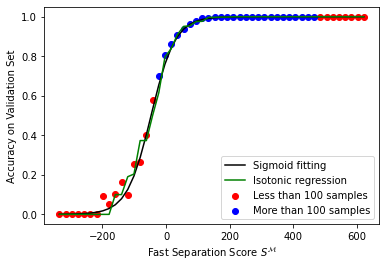

In [4]:
plot_fitting_function(model_info,n_bins=50)

In [7]:
model_info  = load_shuffle(dataset_name='GTSRB_RGB',model_name='GB',shuffle_num=0)

In [ ]:
plot_fitting_function(model_info,n_bins=50)